In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal
from scipy.fftpack import fft

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)

Pytorch: 1.5.0
Fastai2: 0.0.17


# Data

In [2]:
train_x = np.load('data/0_x_train.npy')
train_p = np.load('data/1_linear_preds_train.npy')
train_y = np.load('data/0_y_train.npy')
test_x  = np.load('data/0_x_test.npy')
test_p  = pd.read_csv('../subs/sub_prueba.csv')["open_channels"].values # np.load('data/1_linear_preds_test.npy')

train_x_segments = np.split(train_x, 10)
train_p_segments = np.split(train_p, 10)
train_y_segments = np.split(train_y, 10)
test_x_segments  = np.split(test_x, 20)
test_p_segments  = np.split(test_p, 20)

### TRAIN: CORREGIR Y para igualarlo a X real noise

Batch: 0 	W: 1.2364 	B: -2.72 	Diff std: 0.2483 	Diff mean: -0.000636
Batch: 1 	W: 1.2372 	B: -2.7309 	Diff std: 0.2499 	Diff mean: -5.5e-05
Batch: 2 	W: 1.235 	B: -2.7365 	Diff std: 0.2479 	Diff mean: -0.000395
Batch: 3 	W: 1.2313 	B: -2.7373 	Diff std: 0.2713 	Diff mean: -0.000388
Batch: 4 	W: 1.2337 	B: -5.4597 	Diff std: 0.4122 	Diff mean: -5.4e-05
Batch: 5 	W: 1.2344 	B: -2.734 	Diff std: 0.2918 	Diff mean: -0.000202
Batch: 6 	W: 1.2328 	B: -2.7336 	Diff std: 0.2478 	Diff mean: 0.000647
Batch: 7 	W: 1.2323 	B: -2.7359 	Diff std: 0.6621 	Diff mean: -0.003259
Batch: 8 	W: 1.237 	B: -2.7574 	Diff std: 0.2896 	Diff mean: 3.7e-05
Batch: 9 	W: 1.2331 	B: -5.4575 	Diff std: 0.4127 	Diff mean: -0.000198


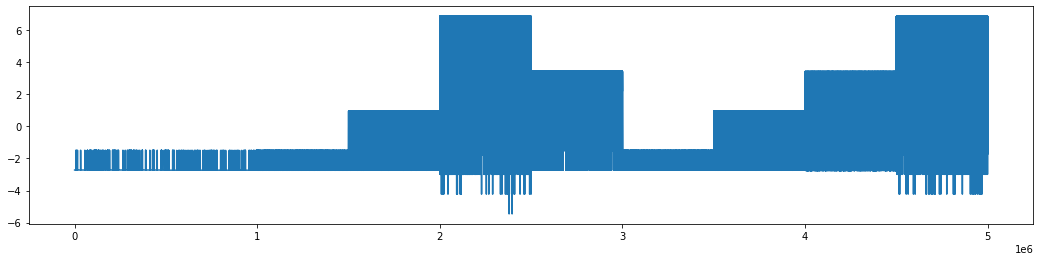

In [3]:
def correct_mae(params):
    w,b = params
    return np.mean(np.abs(x_segment - (y_segment*w + b)))

def correct_mse(params):
    w,b = params
    return np.mean(np.square(x_segment - (y_segment*w + b)))

train_y_corrected = np.array([])
for i,(x_segment, y_segment) in enumerate(zip(train_x_segments, train_y_segments)):
    res = scipy.optimize.minimize(correct_mae, (0.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    y_corrected = y_segment*w + b
    train_y_corrected = np.append(train_y_corrected, y_corrected)
    print("Batch:",i,"\tW:",round(w,4),"\tB:",round(b,4),"\tDiff std:", round((x_segment - y_corrected).std(),  4),
                                                         "\tDiff mean:",round((x_segment - y_corrected).mean(), 6))
plt.figure(figsize=(18, 4)); plt.plot(train_y_corrected);

### TRAIN: CORREGIR P para igualarlo a X

Batch: 0 	W: 1.2699 	B: -2.719 	Diff std: 0.2512 	Diff mean: 0.001692
Batch: 1 	W: 1.2783 	B: -2.7293 	Diff std: 0.2543 	Diff mean: 0.00294
Batch: 2 	W: 1.2378 	B: -2.7408 	Diff std: 0.2469 	Diff mean: -0.002366
Batch: 3 	W: 1.2451 	B: -2.7749 	Diff std: 0.2721 	Diff mean: -0.006398
Batch: 4 	W: 1.2695 	B: -5.7259 	Diff std: 0.363 	Diff mean: -0.001103
Batch: 5 	W: 1.2472 	B: -2.784 	Diff std: 0.2855 	Diff mean: -0.003458
Batch: 6 	W: 1.2358 	B: -2.7382 	Diff std: 0.2469 	Diff mean: -0.001532
Batch: 7 	W: 1.2465 	B: -2.7792 	Diff std: 0.4406 	Diff mean: -0.022345
Batch: 8 	W: 1.2485 	B: -2.8001 	Diff std: 0.283 	Diff mean: -0.001131
Batch: 9 	W: 1.2696 	B: -5.7276 	Diff std: 0.363 	Diff mean: -0.001859


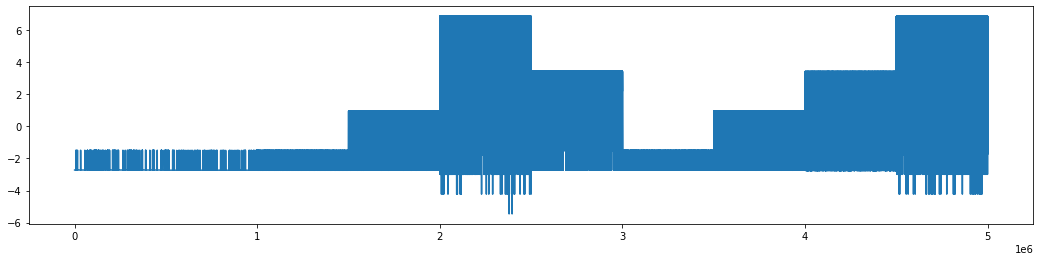

In [4]:
train_p_corrected = np.array([])
for i,(x_segment, y_segment) in enumerate(zip(train_x_segments, train_p_segments)):
    res = scipy.optimize.minimize(correct_mae, (0.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    p_corrected = y_segment*w + b
    train_p_corrected = np.append(train_p_corrected, p_corrected)
    print("Batch:",i,"\tW:",round(w,4),"\tB:",round(b,4),"\tDiff std:", round((x_segment - p_corrected).std(),  4),
                                                         "\tDiff mean:",round((x_segment - p_corrected).mean(), 6))
plt.figure(figsize=(18, 4)); plt.plot(train_y_corrected);

### TEST: CORREGIR P para igualarlo a X

Batch: 0 	W: 1.1818 	B: -5.0556 	Diff std: 0.2409 	Diff mean: -0.004048
Batch: 1 	W: 1.21 	B: -5.1378 	Diff std: 0.2793 	Diff mean: -0.019911
Batch: 2 	W: 1.2244 	B: -5.217 	Diff std: 0.2899 	Diff mean: -0.02235
Batch: 3 	W: 1.2008 	B: -5.096 	Diff std: 0.2406 	Diff mean: -0.004779
Batch: 4 	W: 1.169 	B: -5.029 	Diff std: 0.2489 	Diff mean: -0.013229
Batch: 5 	W: 1.2237 	B: -5.3623 	Diff std: 0.3516 	Diff mean: 0.015223
Batch: 6 	W: 1.2189 	B: -5.1693 	Diff std: 0.292 	Diff mean: -0.026739
Batch: 7 	W: 1.2228 	B: -5.3484 	Diff std: 0.3503 	Diff mean: 0.013259
Batch: 8 	W: 1.2009 	B: -5.1095 	Diff std: 0.2413 	Diff mean: -0.00212
Batch: 9 	W: 1.2113 	B: -5.1379 	Diff std: 0.2776 	Diff mean: -0.021417
Batch: 10 	W: 1.2013 	B: -5.1151 	Diff std: 0.2409 	Diff mean: -0.003493
Batch: 11 	W: 1.192 	B: -5.0794 	Diff std: 0.2408 	Diff mean: -0.003575
Batch: 12 	W: 1.2092 	B: -5.1165 	Diff std: 0.2404 	Diff mean: -0.003636
Batch: 13 	W: 1.2073 	B: -5.1468 	Diff std: 0.2483 	Diff mean: -0.003757


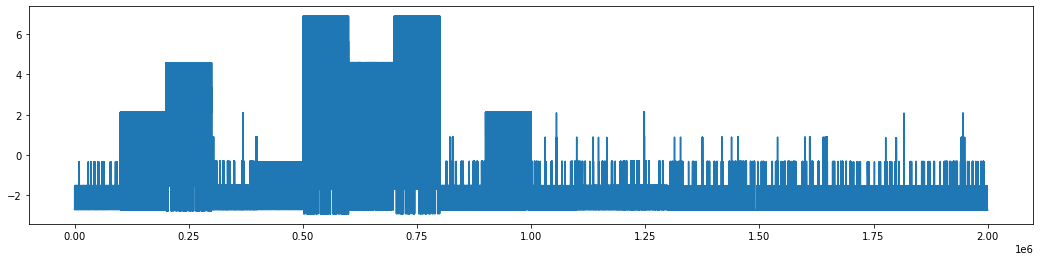

In [5]:
test_p_corrected = np.array([])
for i,(x_segment, y_segment) in enumerate(zip(test_x_segments, test_p_segments)):
    res = scipy.optimize.minimize(correct_mae, (0.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    p_corrected = y_segment*w + b
    test_p_corrected = np.append(test_p_corrected, p_corrected)
    print("Batch:",i,"\tW:",round(w,4),"\tB:",round(b,4),"\tDiff std:", round((x_segment - p_corrected).std(),  4),
                                                         "\tDiff mean:",round((x_segment - p_corrected).mean(), 6))
plt.figure(figsize=(18, 4)); plt.plot(test_p_corrected);

# <center> PART 2.2: Get NOISE (resta)

### Obetener NOISE TRAIN GT

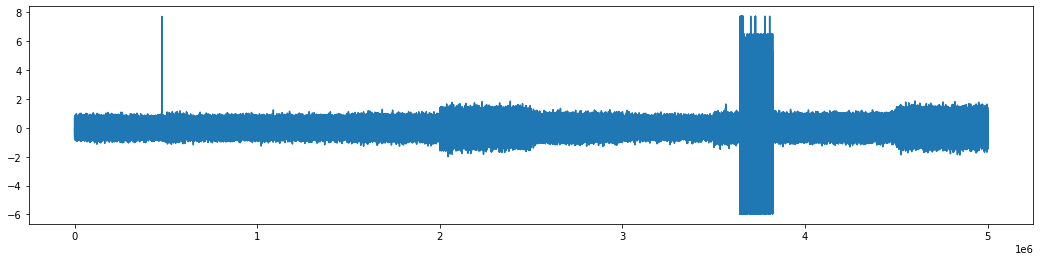

In [6]:
train_noise = train_x - train_y_corrected
plt.figure(figsize=(18, 4)); plt.plot(train_noise);

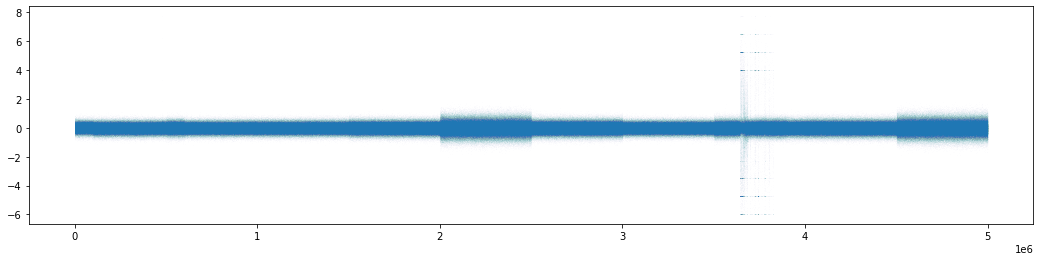

In [7]:
plt.figure(figsize=(18, 4)); plt.scatter(range(5000000),train_noise, s=0.1, alpha=0.01);

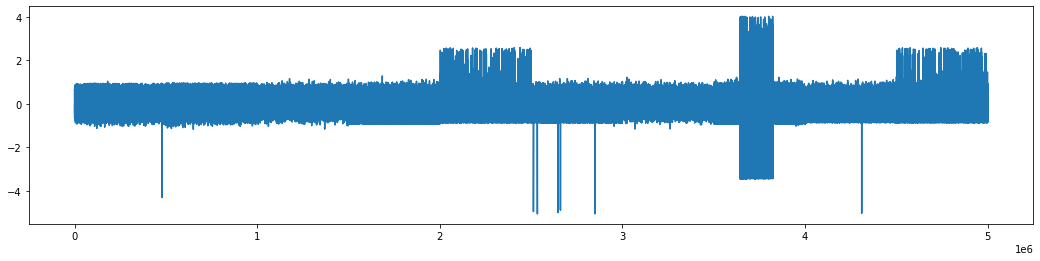

In [8]:
train_noise_p = train_x - train_p_corrected
plt.figure(figsize=(18, 4)); plt.plot(train_noise_p);

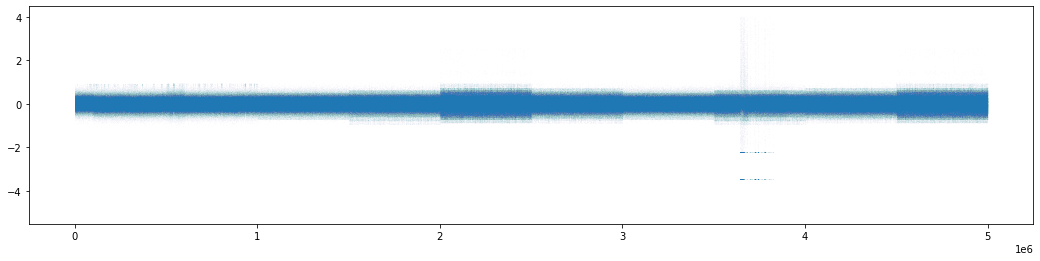

In [9]:
plt.figure(figsize=(18, 4)); plt.scatter(range(5000000),train_noise_p, s=0.1, alpha=0.01);

### Obetener NOISE TEST

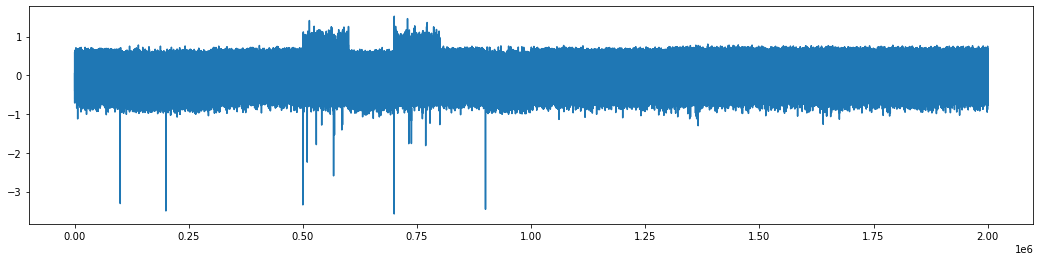

In [10]:
test_noise_p = test_x - test_p_corrected
plt.figure(figsize=(18, 4)); plt.plot(test_noise_p);

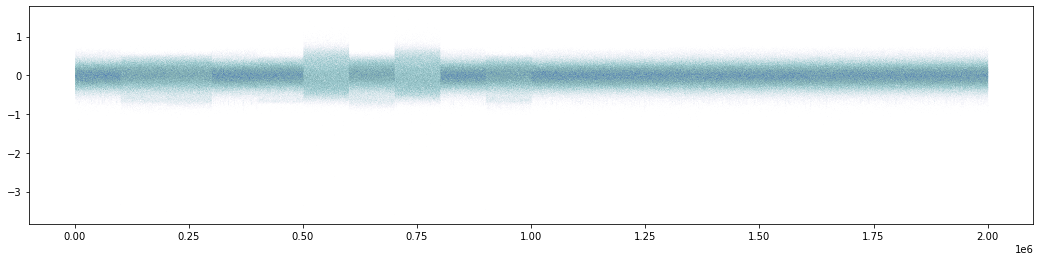

In [11]:
plt.figure(figsize=(18, 4)); plt.scatter(range(2000000), test_noise_p, s=0.2, alpha=0.01);

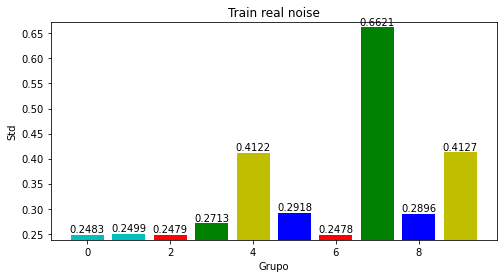

In [12]:
def plot_bar(array, title, xlabel, ylabel, color):
    plt.figure(figsize=(8, 4))
    plt.ylim([min(array)-0.01, max(array)+0.01])
    plot = plt.bar(list(range(len(array))), array, color=color)

    for value in plot:
        height = value.get_height()
        plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
train_noise_stds = [segment.std() for segment in np.split(train_noise, 10)]
plot_bar(train_noise_stds, "Train real noise", "Grupo", "Std", ['c','c','r','g','y','b','r','g','b','y'])

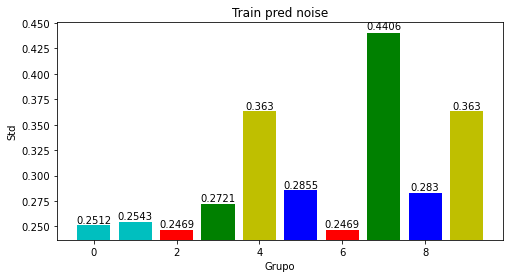

In [13]:
train_noise_p_stds = [segment.std() for segment in np.split(train_noise_p, 10)]
plot_bar(train_noise_p_stds, "Train pred noise", "Grupo", "Std", ['c','c','r','g','y','b','r','g','b','y'])

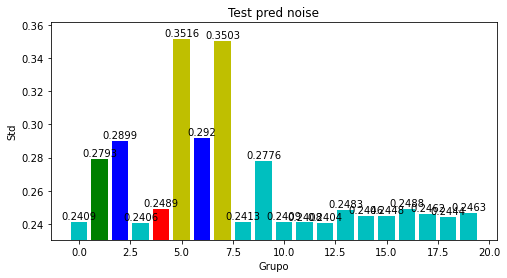

In [14]:
train_noise_stds = [segment.std() for segment in np.split(test_noise_p, 20)]
plot_bar(train_noise_stds, "Test pred noise", "Grupo", "Std",
                ['c', 'g', 'b', 'c', 'r', 'y', 'b', 'y', 'c', 'c',
                'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c'])

# Guardar NOISEs

In [15]:
#np.save('data/2_noise_real_train.npy', train_noise)
#np.save('data/2_noise_linPred_train.npy', train_noise_p)
np.save('data/2_noise_DL_test.npy', test_noise_p)

# EXTRA: Ver Espectogramas

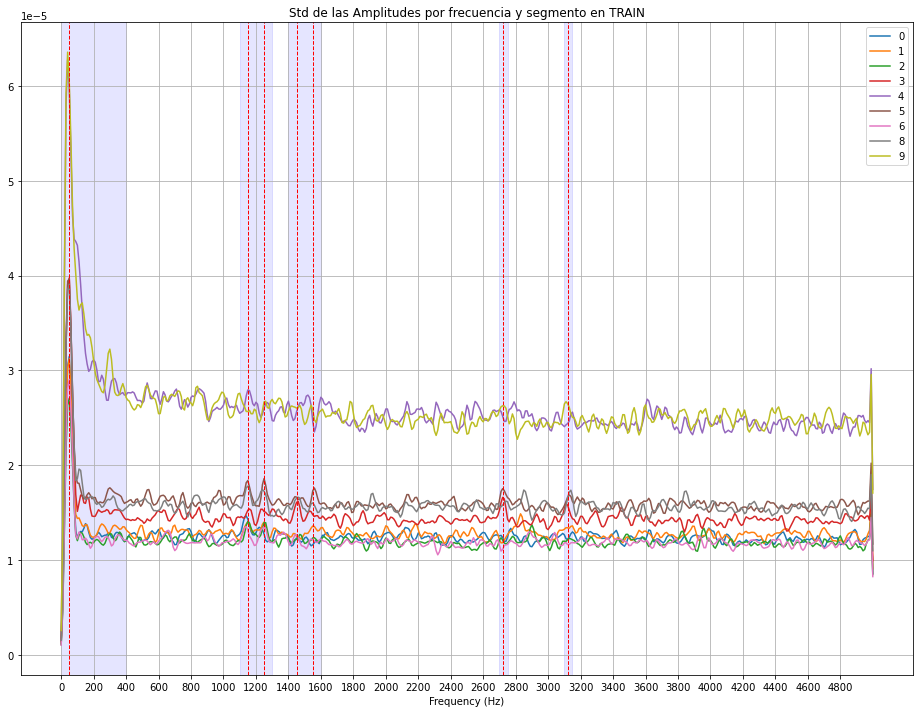

In [14]:
plt.figure(figsize=(16, 12))
plt.grid()
plt.xticks(np.arange(0, 5000, 200))
plt.xlabel("Frequency (Hz)")


for i,n in enumerate(np.split(train_noise, 10)):
    if i==7: continue
    f, t, spec = signal.spectrogram(x=n, fs=10000, nfft=1000)
    plt.plot(f, spec.std(axis=1));

plt.legend([0,1,2,3,4,5,6,8,9])
    
plt.axvspan(0,     400, alpha=0.1, color='blue')
plt.axvspan(1100, 1300, alpha=0.1, color='blue')
plt.axvspan(1400, 1600, alpha=0.1, color='blue')
plt.axvspan(2700, 2750, alpha=0.1, color='blue')
plt.axvspan(3100, 3150, alpha=0.1, color='blue')
plt.axvline(50,   color='r', linestyle='--', linewidth=1)
plt.axvline(1150, color='r', linestyle='--', linewidth=1)
plt.axvline(1250, color='r', linestyle='--', linewidth=1)
plt.axvline(1450, color='r', linestyle='--', linewidth=1)
plt.axvline(1550, color='r', linestyle='--', linewidth=1)
plt.axvline(2725, color='r', linestyle='--', linewidth=1)
plt.axvline(3125, color='r', linestyle='--', linewidth=1)
plt.title("Std de las Amplitudes por frecuencia y segmento en TRAIN");

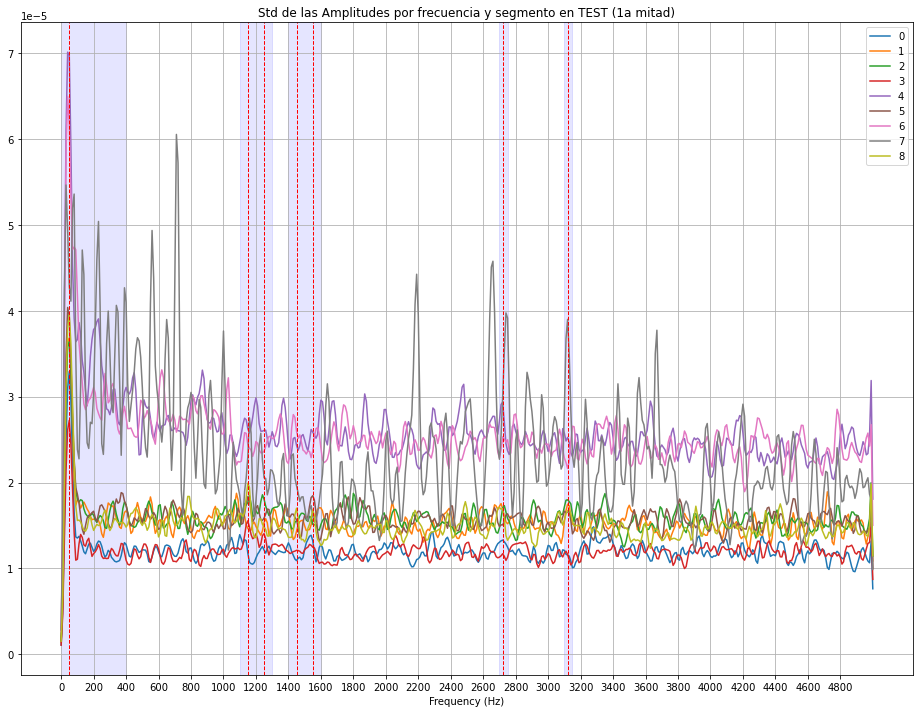

In [15]:
plt.figure(figsize=(16, 12))

plt.grid()
plt.xticks(np.arange(0, 5000, 200))
plt.xlabel("Frequency (Hz)")


for i,n in enumerate(np.split(test_noise, 20)):
    if i==3: continue
    if i==10: break
    f, t, spec = signal.spectrogram(x=n, fs=10000, nfft=1000)
    plt.plot(f, spec.std(axis=1));
plt.legend([str(i) for i in range(9)])
plt.axvspan(0,     400, alpha=0.1, color='blue')
plt.axvspan(1100, 1300, alpha=0.1, color='blue')
plt.axvspan(1400, 1600, alpha=0.1, color='blue')
plt.axvspan(2700, 2750, alpha=0.1, color='blue')
plt.axvspan(3100, 3150, alpha=0.1, color='blue')
plt.axvline(50,   color='r', linestyle='--', linewidth=1)
plt.axvline(1150, color='r', linestyle='--', linewidth=1)
plt.axvline(1250, color='r', linestyle='--', linewidth=1)
plt.axvline(1450, color='r', linestyle='--', linewidth=1)
plt.axvline(1550, color='r', linestyle='--', linewidth=1)
plt.axvline(2725, color='r', linestyle='--', linewidth=1)
plt.axvline(3125, color='r', linestyle='--', linewidth=1)
plt.title("Std de las Amplitudes por frecuencia y segmento en TEST (1a mitad)");